In [67]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import math
import matplotlib.patches as patches


In [101]:
#Domain
DOMAIN_X_SIZE = 2.0
DOMAIN_Y_SIZE = 1.0

#GRID
CELLS_Y = 50
CELLS_X = 2*CELLS_Y
SPACES = DOMAIN_Y_SIZE / CELLS_Y
NX = CELLS_X+1
NY = CELLS_Y+1

#Obstacle
IS_OBSTACLE = True
IS_OBSTACLE_MOVE = False
OBSTACLE_TYPE = 'cylinder'
OBSTACLE_CENTER_X = 0.3 * DOMAIN_X_SIZE
OBSTACLE_CENTER_Y = 0.5 * DOMAIN_Y_SIZE
OBSTACLE_R = 0.15 * min(DOMAIN_Y_SIZE,DOMAIN_X_SIZE)

#Solve
TIME_STEP_LENGTH = 0.001


In [102]:
class Grid:
    def __init__(self,DOMAIN_X_SIZE,DOMAIN_Y_SIZE,SPACES,nx,ny):
        self.lx = DOMAIN_X_SIZE
        self.ly = DOMAIN_Y_SIZE
        self.dh = SPACES
        self.nx = nx
        self.ny = ny
        self.x = np.linspace(0, self.lx, self.nx)
        self.y = np.linspace(0, self.ly, self.ny)

In [103]:
class DATA:
    def __init__(self,x_start,x_end,nx,y_start,y_end,ny,Is_zeros):
        self.crood_x = np.linspace(x_start,x_end,nx)
        self.crood_y = np.linspace(y_start,y_end,ny)
        self.is_zeros = Is_zeros
        if self.is_zeros == True:
            self.data = np.zeros((nx, ny))
        else:
            self.data = np.ones((nx, ny))
        

In [104]:
class Field:
    def __init__(self,DATA_NAME,DATA_TYPE,IS_GOST_CELLS,POINTS_X,POINTS_Y,isZeros):
        self.name = DATA_NAME
        print("New data is created, which named:",self.name)
        self.type = DATA_TYPE
        self.IS_GOST_CELLS = IS_GOST_CELLS
        self.is_zeros = isZeros
        if self.type == 'scalar':
            if self.IS_GOST_CELLS == False:
                self.nx = POINTS_X-1
                self.ny = POINTS_Y-1
                self.scalar = DATA(0.5*SPACES,DOMAIN_X_SIZE - 0.5*SPACES,self.nx,0.5*SPACES,DOMAIN_Y_SIZE - 0.5*SPACES,self.ny,self.is_zeros)
            else:
                self.nx = POINTS_X+1
                self.ny = POINTS_Y+1
                self.scalar = DATA(-0.5*SPACES,DOMAIN_X_SIZE + 0.5*SPACES,self.nx,-0.5*SPACES,DOMAIN_Y_SIZE + 0.5*SPACES,self.ny,self.is_zeros)
        elif self.type == 'vector':
            if self.IS_GOST_CELLS == False:
                self.x_nx = POINTS_X
                self.x_ny = POINTS_Y-1
                self.x_compent = DATA(0,DOMAIN_X_SIZE,self.x_nx,0.5*SPACES,DOMAIN_Y_SIZE - 0.5*SPACES,self.x_ny,self.is_zeros)

                self.y_nx = POINTS_X - 1
                self.y_ny = POINTS_Y
                self.y_compent = DATA(0.5*SPACES,DOMAIN_X_SIZE - 0.5*SPACES,self.y_nx,0,DOMAIN_Y_SIZE,self.y_ny,self.is_zeros)
            else:
                self.x_nx = POINTS_X
                self.x_ny = POINTS_Y + 1
                self.x_compent = DATA(0,DOMAIN_X_SIZE,self.x_nx,-0.5*SPACES,DOMAIN_Y_SIZE + 0.5*SPACES,self.x_ny,self.is_zeros)

                self.y_nx = POINTS_X + 1
                self.y_ny = POINTS_Y
                self.y_compent = DATA(-0.5*SPACES,DOMAIN_X_SIZE + 0.5*SPACES,self.y_nx,0,DOMAIN_Y_SIZE,self.y_ny,self.is_zeros)
        
        
        

In [105]:
class Fluids:
    def __init__(self,DOMAIN_X_SIZE,DOMAIN_Y_SIZE,SPACES,IS_GOST_CELLS,NX,NY,IS_OBSTACLE,IS_OBSTACLE_MOVE,OBSTACLE_TYPE,OBSTACLE_CENTER_X,OBSTACLE_CENTER_Y,OBSTACLE_R):
        self.IS_GOST_CELLS = IS_GOST_CELLS
        self.Field_nx = NX
        self.Field_ny = NY
        self.Grid_Lx = DOMAIN_X_SIZE
        self.Grid_Ly = DOMAIN_Y_SIZE
        self.Grid_h = SPACES
        self.Grid = Grid(self.Grid_Lx,self.Grid_Ly,self.Grid_h,self.Field_nx,self.Field_ny)
        self.p = Field('pressure','scalar',self.IS_GOST_CELLS,self.Field_nx,self.Field_ny,True)
        self.s = Field('Sloid marks','scalar',self.IS_GOST_CELLS,self.Field_nx,self.Field_ny,False)
        self.m = Field('Smoke density','scalar',self.IS_GOST_CELLS,self.Field_nx,self.Field_ny,True)
        self.f = Field('Body force','vector',self.IS_GOST_CELLS,self.Field_nx,self.Field_ny,True)
        self.v = Field('Velocity','vector',self.IS_GOST_CELLS,self.Field_nx,self.Field_ny,True)
        
        self.is_obstacle = IS_OBSTACLE
        if self.is_obstacle == True:
            self.obstacle_type = OBSTACLE_TYPE
            self.obstacle_cx = OBSTACLE_CENTER_X
            self.obstacle_cy = OBSTACLE_CENTER_Y
            self.obstacle_r = OBSTACLE_R
            print("There is a obstacle in Domain, which named:",self.obstacle_type," and (center_x, center_y, R) = ", self.obstacle_cx,',',self.obstacle_cy,',',self.obstacle_r)
            self.is_obstacle_move = IS_OBSTACLE_MOVE
            
            if self.is_obstacle_move ==True:
                print("The obstacle is moving!!")
            else:
                print("The obstacle is not moving !!")
                
    def set_obstacle(self):
        cx = self.obstacle_cx
        cy = self.obstacle_cy
        r = self.obstacle_r
        crood_x_s = self.s.scalar.crood_x
        crood_y_s = self.s.scalar.crood_y
        if self.is_obstacle_move == False:
            vx = 0
            vy = 0
        else:
            print("You need know the action of obstacle!!")
        
        for i in range(1,len(crood_x_s)-1):
            for j in range(1,len(crood_y_s)-1):
                dx = crood_x_s[i] - cx
                dy = crood_y_s[j] - cy
                r1 = math.sqrt(dx**2 + dy**2)
                if r1<r:
                    self.s.scalar.data[i,j] = 0
                    self.m.scalar.data[i,j] = 1
                    self.v.x_compent.data[i+1,j] = vx
                    self.v.x_compent.data[i,j] = vx
                    self.v.y_compent.data[i,j+1] = vy
                    self.v.y_compent.data[i,j] = vy

    def plot_obstacle_grid(self):
        if self.is_obstacle == True:
            self.set_obstacle()
            fig, ax = plt.subplots(figsize=(12, 6))
            for x in self.Grid.x:
                ax.plot([x, x], [self.Grid.y[0], self.Grid.y[-1]], color='black', linewidth=0.5)
            for y in self.Grid.y:
                ax.plot([self.Grid.x[0], self.Grid.x[-1]], [y, y], color='black', linewidth=0.5)
            data = self.s.scalar.data
            x_crood = self.s.scalar.crood_x
            y_crood = self.s.scalar.crood_y
            x_nodes, y_nodes = np.meshgrid(x_crood, y_crood, indexing='ij')
            h = self.Grid.dh  # 网格间距
            
            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    color = 'black' if data[i, j] == 0 else 'white'
                    rect = patches.Rectangle(
                        (x_crood[i] - 0.5 * h, y_crood[j] - 0.5 * h),  # 左下角坐标
                        h, h,
                        facecolor=color,
                        edgecolor='gray',
                        linewidth=0.3
                    )
                    ax.add_patch(rect)

            ax.set_aspect('equal')
            ax.set_xlim([0 - 2*h, self.Grid_Lx + 2*h])
            ax.set_ylim([0 - 2*h, self.Grid_Ly + 2*h])
            ax.set_title("Obstacle Field (s): black = obstacle (0), white = fluid (1)")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.show()
        else:
            print("ERROR: There is no obstacle")
        
    
    def plot_data_grid(self):
        fig, ax = plt.subplots(figsize=(12, 6))

        for x in self.Grid.x:
            ax.plot([x, x], [self.Grid.y[0], self.Grid.y[-1]], color='black', linewidth=0.5)
        for y in self.Grid.y:
            ax.plot([self.Grid.x[0], self.Grid.x[-1]], [y, y], color='black', linewidth=0.5)

        label_used = {}
        def plot_unique(data, marker, color, label):
            x_nodes, y_nodes = np.meshgrid(data.crood_x, data.crood_y, indexing='ij')
            if label not in label_used:
                ax.scatter(x_nodes, y_nodes, s=5, marker=marker, color=color, label=label)
                label_used[label] = True
            else:
                ax.scatter(x_nodes, y_nodes, s=5, marker=marker, color=color)

        plot_unique(self.p.scalar, 's', 'red', 'Pressure (p)')
        #plot_unique(self.s.scalar, 's', 'orange', 'Solid mark (s)')
        #plot_unique(self.m.scalar, 's', 'green', 'Smoke (m)')
        #plot_unique(self.fx.scalar, '^', 'blue', 'Body force fx')
        #plot_unique(self.fy.scalar, 'v', 'cyan', 'Body force fy')

        plot_unique(self.v.x_compent, '>', 'blue', 'Velocity u (x-comp)')
        plot_unique(self.v.y_compent, '^', 'green', 'Velocity v (y-comp)')

        ax.set_aspect('equal')
        if self.IS_GOST_CELLS == False:
            ax.set_title("Staggered Grid Layout and Variable Positions without Gost Cells")
        else:
            ax.set_title("Staggered Grid Layout and Variable Positions with Gost Cells")
        ax.legend(loc='upper right')
        ax.set_xlim([0-2*self.Grid_h, self.Grid_Lx + 2*self.Grid_h])
        ax.set_ylim([0-2*self.Grid_h, self.Grid_Ly + 2*self.Grid_h])
        plt.xlabel("X")
        plt.ylabel("Y")
        #plt.grid(True)
        plt.show()
    

New data is created, which named: pressure
New data is created, which named: Sloid marks
New data is created, which named: Smoke density
New data is created, which named: Body force
New data is created, which named: Velocity
There is a obstacle in Domain, which named: cylinder  and (center_x, center_y, R) =  0.6 , 0.5 , 0.15
The obstacle is not moving !!


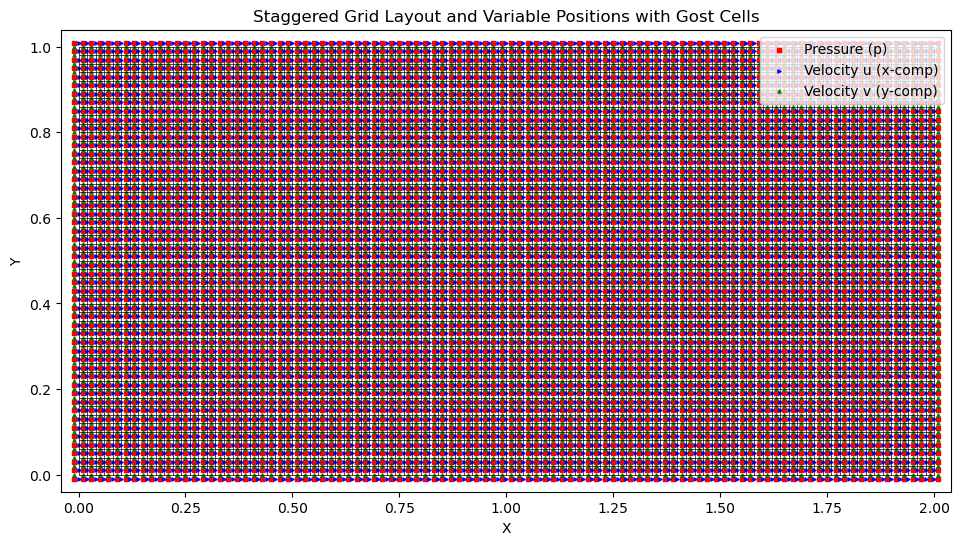

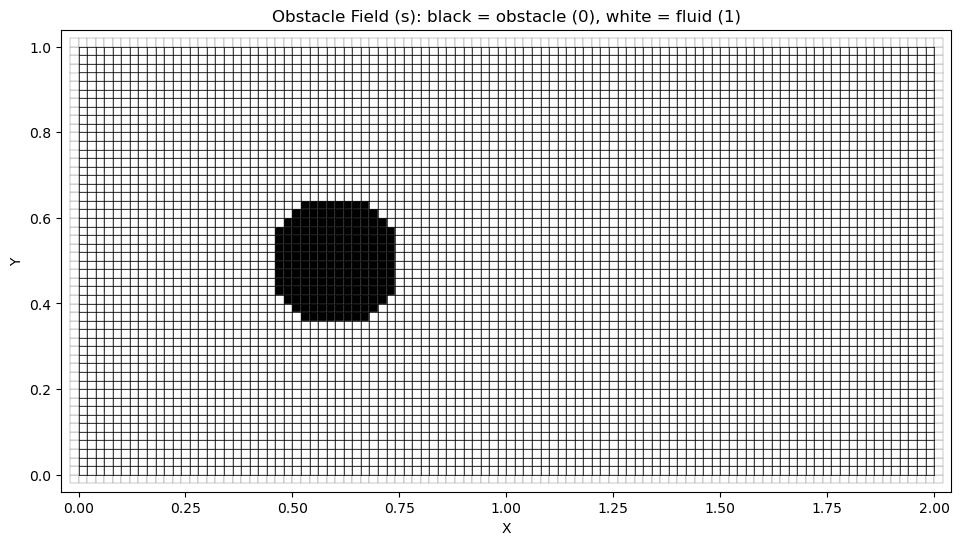

In [108]:
show_Fluid1 = Fluids(DOMAIN_X_SIZE,DOMAIN_Y_SIZE,SPACES,True,NX,NY,IS_OBSTACLE,IS_OBSTACLE_MOVE,OBSTACLE_TYPE,OBSTACLE_CENTER_X,OBSTACLE_CENTER_Y,OBSTACLE_R)
show_Fluid1.plot_data_grid()
show_Fluid1.plot_obstacle_grid()

In [ ]:
class Solver:
    def __init__(Fluid,TIME_STEP_LENGTH,numIters):
        self.fluid = Fluid
        self.dt = TIME_STEP_LENGTH
        self.numIters = numIters
        self.density = 1.0
    def force_time_integrate():
        self.fluid.v.x_compent.data[:,1:-1] += self.fluid.f.x_compent.data[:,1:-1] * self.dt
        self.fluid.v.y_compent.data[1:-1,:] += self.fluid.f.y_compent.data[1:-1,:] * self.dt
        self.fluid.set_obstacle()
    def Solve_Mass_Poisson():
        cp = self.density * self.fluid.Grid_h / self.dt
        